In [1]:
%matplotlib inline

In [2]:
cd ..

C:\Users\alferreira\Downloads\stocks


In [3]:
from matplotlib import pyplot as plt
import numpy as np
import copy
import torch as th
import torch.nn.functional as F
from torch.optim import lr_scheduler
import scipy
import sys
import pandas as pd
from Tools.util import progressbar

### Load Vectors Ready for Training

In [4]:
cd data

C:\Users\alferreira\Downloads\stocks\data


In [5]:
import os
import sys
import pandas as pd
import numpy as np
import struct
import datetime
import calendar
import time
import argparse
from Tools.util import progressbar
from Tools import prepareData, torchNN
from Tools import meta5Ibov

In [ ]:
# Working Path for Expert Advisor Metatrader 5
# Use same path that can be read by the expert advisor
datapath = "C:\\Users\\alferreira\\Downloads\\stocks\\data"
#datapath = "/home/andre/Projects/stocks/data"
os.chdir(datapath)
# staistical mean and variance from 2013+2018 used to make data
# with variance < 1 and mean close to 0, that is how it works!
#stocks_stats = pd.read_csv('stocks_stats_2018.csv', index_col=0)
# selected columns by backtesting best performance accuracy
with open('collumns_selected.txt', 'r') as f: # txt column names divided by spaces
    columns = f.read()
selected_columns = columns.split(' ')[:-1]
#datapath = '/home/andre/.wine/drive_c/Program Files/Rico MetaTrader 5/MQL5/Files'
meta5Ibov.setDataPath(datapath, datapath, verbose=False)
# don't want masterdf to be reused
masterdf = meta5Ibov.loadMeta5Data(suffix='M1.mt5bin',
            cleandays=True, verbose=True)
masterdf = meta5Ibov.simpleColumnNames()

In [8]:
percmiss = meta5Ibov.calculateMissing(masterdf)
X, y, Xp = prepareData.GetTrainingPredictionVectors(
    masterdf.copy(), targetsymbol='PETR4_C', verbose=False,
    span=90, stats=None, selected=selected_columns)

In [9]:
#X.to_pickle('X_train_20180823_all_nobuckets_nopercentiles_nostdn.pickle')
#y.to_pickle('Y_train_20180823_all_nobuckets_nopercentiles_nostdn.pickle')

In [7]:
X = pd.read_pickle('X_train_20180823_all_nobuckets_nopercentiles_nostdn.pickle')
y = pd.read_pickle('Y_train_20180823_all_nobuckets_nopercentiles_nostdn.pickle')

In [8]:
# X = X[:80000]
# y = y[:80000]

In [9]:
X.shape

(504965, 148)

Clean up training samples  

1:30 hours = 90 minutes  

day has 7 hours for trading == 7*60 = 420  
420-90-90 = 240 boundaries make left = 4 hours  

In [10]:
X['day'] = X.index.map(lambda x: x.date())

In [11]:
for day, group in X.groupby('day'):
    if len(group) < 60*4: # less than 4 hours cannot daytrade with 2/3 hours boundary
        X.drop(group.index, inplace=True)

In [12]:
X['start'] = X.day.map(lambda x: datetime.datetime(x.year, x.month, x.day, 11, 30, 0))
X['end'] = X.day.map(lambda x: datetime.datetime(x.year, x.month, x.day, 15, 30, 0))
Xn = X.query('index > start and index < end').copy()
Xn.drop(columns=['day', 'start', 'end'], inplace=True)
Yn = y[Xn.index]

In [13]:
Yn.tail(3)

time
2018-07-27 15:22:00    1.0
2018-07-27 15:23:00    1.0
2018-07-27 15:24:00    1.0
Name: y, dtype: float64

In [14]:
Xn.head(3)

,BBAS3_O,BBAS3_T,BBAS3_R,DOL$_O,DOL$_T,DOL$_R,VALE3_O,VALE3_T,VALE3_R,ABEV3_O,...,dema_2hour,macdhour,macd_meanhour,ema_2weekday,dema_2weekday,macdweekday,macd_meanweekday,rsi_2weekday,ema_2minute,macdminute
time,,,,,,,,,,,,,,,,,,,,,
2013-07-02 11:31:00,-1.039078,-0.234609,-0.621252,-0.517422,1.251865,1.862783,-0.185586,-0.132574,-0.098213,-1.229889,...,-0.871298,0.169966,-1.602625,-1.148629,0.632565,0.021266,0.896495,0.723836,-1.542713,0.397759
2013-07-02 11:32:00,-1.037687,-0.030084,-0.261802,-0.515785,1.626139,1.169825,-0.185586,-0.525525,-0.583688,-1.225708,...,-0.861675,0.158380,-1.595915,-1.144886,0.625563,0.019656,0.893689,0.723836,-1.508259,0.459120
2013-07-02 11:33:00,-1.037687,0.112929,-0.352245,-0.517422,1.327723,0.199945,-0.187598,-0.525525,-0.649792,-1.229889,...,-0.852158,0.147496,-1.589038,-1.141185,0.618639,0.018165,0.890757,0.723836,-1.466666,0.516576


In [15]:
device = torchNN.getDevice()

In [16]:
device

device(type='cuda')

In [17]:
# tensors cannot be used with sklearn train_test_split
# Xth, Yth = torchNN.dfvectorstoTensor(Xn, Yn, device)
# Xth = torchNN.tensorNormalize(Xth)

In [18]:
torchNN.setSeed(device, 25640) # reproducible

In [19]:
len(Xn)

288190

In [20]:
def indexSequentialFolds(length, size, verbose=True):
    nfolds = length-size
    indexfold = np.zeros((nfolds, 2), dtype=int) # begin and end 2
    for i in range(nfolds):
        indexfold[i, :] = np.array([i, i+size], dtype=int)    
    print('number folds ', nfolds)
    return indexfold, nfolds

Train in **1 year** and test on the subsequent **6 months**

In [21]:
#indextrain, indextest, nfolds = indexSequentialFolds(len(Xn), 4*60*5*4, 4*60)
ntrain= 4*60*5*4*12
ntest = 4*60*5*4*6
indexfolds, nfolds = indexSequentialFolds(len(Xn), ntrain+ntest)

number folds  201790


Get a random begin on data of 5 years

In [22]:
i = np.random.randint(nfolds)

Locally normalize mean = 0 and variance to 1

In [23]:
Xfold, yfold  = Xn[indexfolds[i,0]:indexfolds[i,1]].copy(), Yn[indexfolds[i,0]:indexfolds[i,1]].copy()
Xfold = (Xfold - Xfold.mean())/Xfold.std() # normalize variance=1 mean=0

In [24]:
# tensors
Xt, yt = torchNN.dfvectorstoTensor(Xfold[:ntrain], yfold[:ntrain], device) 
Xs, ys = torchNN.dfvectorstoTensor(Xfold[-ntest:], yfold[-ntest:], device)

In [26]:
classifier = torchNN.BinaryNN(dropout=0.3, learn=5e-4, patience=7)

In [27]:
classifier.fit(Xt, yt, Xs, ys, device, epochs=15, batch=64, score=0.5, gma=0.925, verbose=False)

early stopped: no progress on validation.........................................] 4949/13500


0.5401736497879028

In [28]:
results = classifier.results()

In [29]:
results.head()

,t_loss,v_loss,accuracy
epochs,,,
0.5,0.688614,0.690170,0.548194
1.0,0.673925,0.699148,0.525278
1.5,0.669154,0.687365,0.540174
2.0,0.652748,0.712441,0.541250
2.5,0.645573,0.706489,0.537812


### Best 54% on validation

- `gamma`  should not be too high (~0.9) otherwise we have overfitting on training set 
- a low `gamma` value makes it go to a local minima that is the validation minima

Text(0.5,0,'epochs')

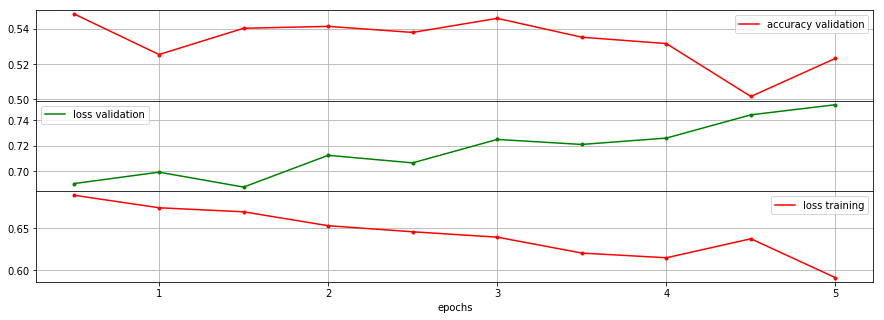

In [31]:
xlim = 1200#len(errort)#40 #len(errort) #50#len(errort) #310
epochs = results.index[-xlim:]
losst = results.t_loss.values[-xlim:]
lossv = results.v_loss.values[-xlim:]
acc = results.accuracy.values[-xlim:]
f, axr = plt.subplots(3, sharex=True, figsize=(15,5))
f.subplots_adjust(hspace=0)
axr[0].plot(epochs, acc, '.r')
axr[0].plot(epochs, acc, '-r', label='accuracy validation')
#axr[0].set_xscale('log')
axr[0].grid()
axr[0].legend()
axr[1].plot(epochs, lossv, '.g')
axr[1].plot(epochs, lossv, '-g', label='loss validation')
axr[1].grid()
axr[1].legend()
axr[2].plot(epochs, losst, '.r')
axr[2].plot(epochs, losst, '-r', label='loss training')
axr[2].grid()
axr[2].legend()
axr[2].set_xlabel('epochs')

### Cross validation Sequential Folds - 30 random samples

In [32]:
#def cross_validate
ntrain= 4*60*5*4*12
ntest = 4*60*5*4*6
indexfolds, nfolds = indexSequentialFolds(len(Xn), ntrain+ntest)
accuracies = [] # validation accuracies
for n in range(30):
    i = np.random.randint(nfolds)
    Xfold, yfold  = Xn[indexfolds[i,0]:indexfolds[i,1]].copy(), Yn[indexfolds[i,0]:indexfolds[i,1]].copy()
    Xfold = (Xfold - Xfold.mean())/Xfold.std() # normalize variance=1 mean=0
    # tensors
    Xt, yt = torchNN.dfvectorstoTensor(Xfold[:ntrain], yfold[:ntrain], device) 
    Xs, ys = torchNN.dfvectorstoTensor(Xfold[-ntest:], yfold[-ntest:], device)
    classifier = torchNN.BinaryNN(dropout=0.3, learn=5e-4, patience=7)
    accuracy = classifier.fit(Xt, yt, Xs, ys, device, epochs=15, batch=64, score=0.5, gma=0.925, verbose=False)
    accuracies.append(accuracy)

number folds  201790
early stopped: no progress on validation.........................................] 5849/13500
early stopped: no progress on validation.........................................] 4949/13500
early stopped: no progress on validation.........................................] 4499/13500
early stopped: no progress on validation.........................................] 5849/13500
early stopped: no progress on validation.........................................] 4499/13500
early stopped: no progress on validation.........................................] 4949/13500
early stopped: no progress on validation.........................................] 5399/13500
early stopped: no progress on validation.........................................] 4499/13500
early stopped: no progress on validation.........................................] 4499/13500
early stopped: no progress on validation.........................................] 6749/13500
early stopped: no progress on validatio

In [34]:
accuracies = np.array(accuracies)

In [47]:
def probability(values):
    percentiles = np.percentile(values, [0, 1, 10, 50, 90])
    print('percentiles are ', percentiles)
    import matplotlib.ticker as plticker
    loc = plticker.MultipleLocator(base=1.0) # this locator puts ticks at regular intervals
    fig = plt.figure(figsize=(10,4))
    ax1 = fig.add_subplot(211);
    ax1.hist(values, bins=20, density=True);
    #ax1.set_xlim(percentiles[0], 5)
    ax1.xaxis.set_major_locator(loc)
    ax1.grid()
    ax2 = fig.add_subplot(212, sharex=ax1)
    ax2.hist(values, bins=20, density=True, cumulative=True);
    ax2.xaxis.set_major_locator(loc)
    ax2.set_ylabel('cumulative percentage (%)')
    ax2.grid()

percentiles are  [0.48138887 0.48906178 0.53103819 0.56269097 0.58770832]


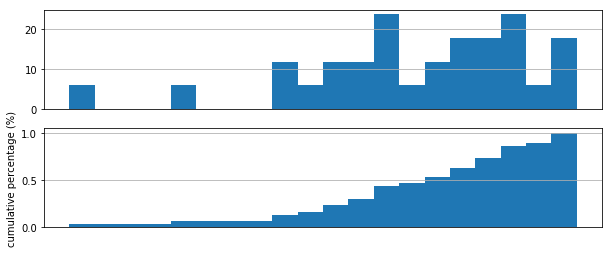

In [50]:
probability(accuracies);

### Create predictions 90 minutes following 6 months

In [51]:
def predictWindowed(model, X, size):
    nshifts = len(X)-size    
    # sliding window with step of one sample shift
    prediction_book = th.zeros([nshifts, 2], dtype=th.float32)
    model.eval()
    with th.no_grad():
        for i in progressbar(range(nshifts)):
            yp = model(X[i:i+size])
            yp = th.argmax(yp, 1)
            prediction_book[i, 0] = i+size
            prediction_book[i, 1] = th.sum(yp)    
    return prediction_book

In [53]:
predictionbook = predictWindowed(classifier, Xs, 90)

[################################################################################] 28710/28710


In [54]:
predictionbook = predictionbook.numpy()

In [55]:
np.unique(predictionbook)

array([0.0000e+00, 1.0000e+00, 2.0000e+00, ..., 2.8797e+04, 2.8798e+04,
       2.8799e+04], dtype=float32)

In [56]:
dfpredictions = pd.DataFrame(predictionbook, columns=['time', 'direction'])

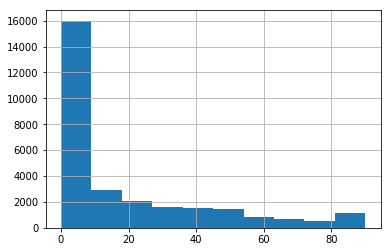

In [57]:
dfpredictions.direction.hist()

In [58]:
dfpredictions['buy'] = np.nan
dfpredictions.loc[dfpredictions.direction >= 0.9*120, 'buy'] = 1
dfpredictions.loc[dfpredictions.direction <= .1*120, 'buy'] = -1

In [59]:
dfpredictions.time = Xn.index.values[dfpredictions.time.astype(np.int)]

In [60]:
dfpredictions.dropna(inplace=True)

In [61]:
len(dfpredictions)

17425

In [62]:
dfpredictions.head()

,time,direction,buy
0,2013-07-02 13:03:00,0.0,-1.0
1,2013-07-02 13:04:00,0.0,-1.0
2,2013-07-02 13:05:00,0.0,-1.0
3,2013-07-02 13:06:00,0.0,-1.0
4,2013-07-02 13:07:00,0.0,-1.0


In [63]:
dfpredictions.drop(columns='direction', inplace=True)

In [64]:
dfpredictions.to_pickle('predictions_global_model_55perc.pickle')